In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
plt.style.use("ggplot")


In [7]:
df = pd.read_csv("vehicles.csv")

df.head()

df.info()
df.describe(include="all").T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,426880.0,NaN,NaN,NaN,7311486634.224333,4473170.412559,7207408119.0,7308143339.25,7312620821.0,7315253543.5,7317101084.0
url,426880,426880,https://prescott.craigslist.org/cto/d/prescott...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region,426880,404,columbus,3608,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region_url,426880,413,https://spokane.craigslist.org,2988,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,426880.0,NaN,NaN,NaN,75199.033187,12182282.173598,0.0,5900.0,13950.0,26485.75,3736928711.0
year,425675.0,NaN,NaN,NaN,2011.235191,9.45212,1900.0,2008.0,2013.0,2017.0,2022.0
manufacturer,409234,42,ford,70985,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model,421603,29667,f-150,8009,NaN,NaN,NaN,NaN,NaN,NaN,NaN
condition,252776,6,good,121456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cylinders,249202,8,6 cylinders,94169,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Drop rows with missing price
df = df.dropna(subset=["price"])

# Filter out implausible prices
df = df[(df["price"] > 1000) & (df["price"] < 1000000)]

if "odometer" in df.columns:
    df = df[(df["odometer"] > 0) & (df["odometer"] < 400000)]

# Drop obvious duplicates
df = df.drop_duplicates()

df = df[(df["year"] >= 1980) & (df["year"] <= 2021)]

print("Rows after cleaning:", len(df))


Rows after cleaning: 365743


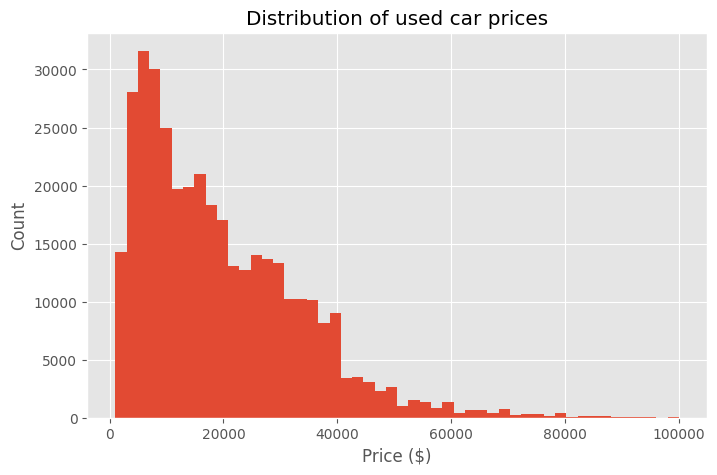

In [19]:
plt.figure(figsize=(8, 5))
plt.hist(df["price"], bins=50)
plt.xlabel("Price ($)")
plt.ylabel("Count")
plt.title("Distribution of used car prices")
plt.show()


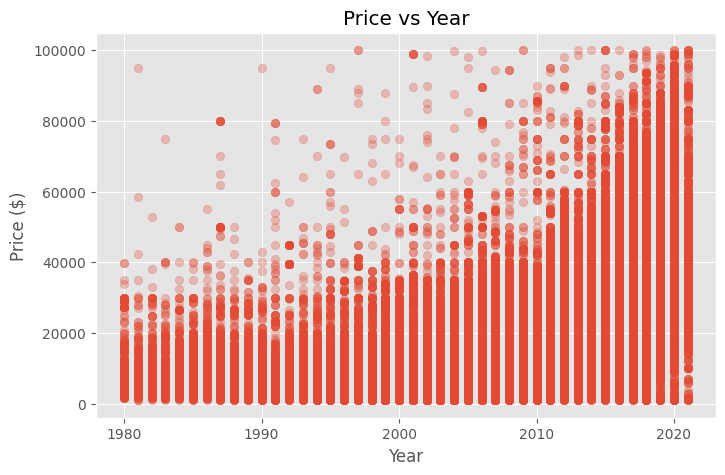

In [20]:
if "year" in df.columns:
    plt.figure(figsize=(8, 5))
    plt.scatter(df["year"], df["price"], alpha=0.3)
    plt.xlabel("Year")
    plt.ylabel("Price ($)")
    plt.title("Price vs Year")
    plt.show()


In [27]:
target_col = "price"

numeric_features = []
if "year" in df.columns:
    numeric_features.append("year")
if "odometer" in df.columns:
    numeric_features.append("odometer")

categorical_features = []
for col in ["manufacturer", "condition", "cylinders", "fuel", "transmission"]:
    if col in df.columns:
        categorical_features.append(col)

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


Numeric features: ['year', 'odometer']
Categorical features: ['manufacturer', 'condition', 'cylinders', 'fuel', 'transmission']


In [28]:

model_df = df[numeric_features + categorical_features + [target_col]].copy()

# One-hot encode categorical columns
model_df = pd.get_dummies(model_df, columns=categorical_features, drop_first=True)

model_df.head()


,year,odometer,price,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,manufacturer_chevrolet,...,cylinders_5 cylinders,cylinders_6 cylinders,cylinders_8 cylinders,cylinders_other,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,transmission_manual,transmission_other
27,2014.0,57923.0,33590,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,True
28,2010.0,71229.0,22590,False,False,False,False,False,False,True,...,False,False,True,False,False,True,False,False,False,True
29,2020.0,19160.0,39590,False,False,False,False,False,False,True,...,False,False,True,False,False,True,False,False,False,True
30,2017.0,41124.0,30990,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,True
31,2013.0,128000.0,15000,False,False,False,False,False,False,False,...,False,True,False,False,False,True,False,False,False,False


In [29]:
X = model_df.drop(columns=[target_col])
y = model_df[target_col].values

X.shape, y.shape


((365743, 61), (365743,))

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

X_train.shape, X_test.shape


((292594, 61), (73149, 61))

In [31]:
X_train.shape, X_test.shape



((292594, 61), (73149, 61))

In [32]:
rf = RandomForestRegressor(
    n_estimators=50,
    max_depth=15,
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)


,n_estimators,50
,criterion,'squared_error'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predictions
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae  = mean_absolute_error(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse  = np.sqrt(mean_squared_error(y_test, y_test_pred))

train_r2 = r2_score(y_train, y_train_pred)
test_r2  = r2_score(y_test, y_test_pred)

print(f"Train MAE:  ${train_mae:,.0f}")
print(f"Test MAE:   ${test_mae:,.0f}")
print()
print(f"Train RMSE: ${train_rmse:,.0f}")
print(f"Test RMSE:  ${test_rmse:,.0f}")
print()
print(f"Train R²:   {train_r2:.3f}")
print(f"Test R²:    {test_r2:.3f}")


Train MAE:  $3,903
Test MAE:   $4,059

Train RMSE: $6,058
Test RMSE:  $6,319

Train R²:   0.818
Test R²:    0.802


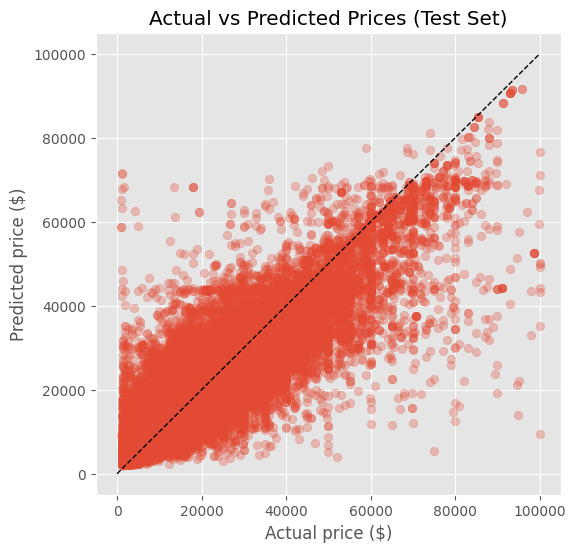

In [36]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.3)
plt.xlabel("Actual price ($)")
plt.ylabel("Predicted price ($)")
plt.title("Actual vs Predicted Prices (Test Set)")

max_val = max(y_test.max(), y_test_pred.max())
plt.plot([0, max_val], [0, max_val], "k--", linewidth=1)

plt.show()


In [37]:
importances = rf.feature_importances_
feature_names = X.columns

fi = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

fi.head(20)


,feature,importance
0,year,0.534086
1,odometer,0.113562
50,cylinders_4 cylinders,0.074739
56,fuel_gas,0.073207
53,cylinders_8 cylinders,0.053927
44,condition_good,0.018921
58,fuel_other,0.012066
57,fuel_hybrid,0.010329
52,cylinders_6 cylinders,0.009152
35,manufacturer_ram,0.007365


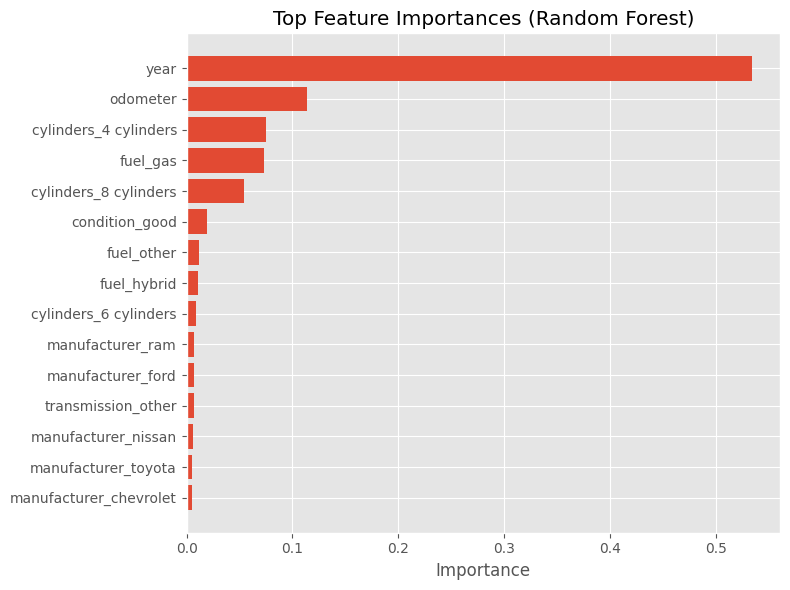

In [38]:
top_n = 15
plt.figure(figsize=(8, 6))
plt.barh(fi["feature"].head(top_n)[::-1], fi["importance"].head(top_n)[::-1])
plt.xlabel("Importance")
plt.title("Top Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()


In [39]:
# Get the indices of the test rows
test_indices = X_test.index

# Copy the original rows for those cars
results_df = df.loc[test_indices].copy()

# Add prediction info
results_df["actual_price"] = y_test
results_df["predicted_price"] = y_test_pred
results_df["error"] = results_df["predicted_price"] - results_df["actual_price"]
results_df["abs_error"] = results_df["error"].abs()

results_df.head()


,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,description,county,state,lat,long,posting_date,actual_price,predicted_price,error,abs_error
44511,7313470556,https://palmsprings.craigslist.org/ctd/d/cathe...,palm springs,https://palmsprings.craigslist.org,42115,2021.0,ford,f-150 xl crew cab,excellent,6 cylinders,...,2021 Ford F150 F 150 F-150 XL Crew Cab - Finan...,NaN,ca,33.777106,-116.452952,2021-04-27T12:02:31-0700,42115,43643.518073,1528.518073,1528.518073
378367,7316895547,https://mcallen.craigslist.org/ctd/d/liberty-h...,mcallen / edinburg,https://mcallen.craigslist.org,36499,2013.0,chevrolet,2500hd lt duramax 4x4,NaN,NaN,...,CALL OR TEXT 512-914-8066 www.GETADIESEL.com ...,NaN,tx,30.663000,-97.931600,2021-05-04T14:40:59-0500,36499,30837.737778,-5661.262222,5661.262222
356469,7304001068,https://knoxville.craigslist.org/ctd/d/alcoa-2...,knoxville,https://knoxville.craigslist.org,7995,2011.0,nissan,juke,NaN,4 cylinders,...,2011 Nissan_ JUKE_ SV Offered by:...,NaN,tn,35.839944,-83.968088,2021-04-08T22:48:05-0400,7995,6959.198506,-1035.801494,1035.801494
122464,7315842209,https://atlanta.craigslist.org/nat/cto/d/kenne...,atlanta,https://atlanta.craigslist.org,64975,2017.0,chevrolet,camaro zl1,excellent,8 cylinders,...,"2017 Chevrolet Camaro ZL1 -18,000 miles -Autom...",NaN,ga,34.028700,-84.604700,2021-05-02T14:11:00-0400,64975,42543.307143,-22431.692857,22431.692857
333648,7313395589,https://philadelphia.craigslist.org/ctd/d/morr...,philadelphia,https://philadelphia.craigslist.org,17900,2018.0,toyota,camry,NaN,4 cylinders,...,This Toyota Camry can be yours today!If you ha...,NaN,pa,40.208400,-74.829100,2021-04-27T13:03:06-0400,17900,22841.802887,4941.802887,4941.802887


In [40]:
worst_5 = results_df.sort_values(by="abs_error", ascending=False).head(5)

cols_to_show = ["actual_price", "predicted_price", "error", "abs_error"]

for col in ["year", "manufacturer", "model", "odometer", "condition", "fuel", "transmission"]:
    if col in worst_5.columns:
        cols_to_show.append(col)

worst_5_display = worst_5[cols_to_show]
worst_5_display


,actual_price,predicted_price,error,abs_error,year,manufacturer,model,odometer,condition,fuel,transmission
247796,99950,9351.076859,-90598.923141,90598.923141,2013.0,nissan,juke s,90000.0,excellent,gas,automatic
321871,94850,14023.388056,-80826.611944,80826.611944,1990.0,ferrari,348 tb,7323.0,NaN,gas,manual
386241,94500,21078.584004,-73421.415996,73421.415996,2007.0,NaN,Peterbilt 335,134884.0,NaN,diesel,manual
43795,94990,22145.298391,-72844.701609,72844.701609,2012.0,NaN,BENTLEY GT W12 TWIN TURBO,17000.0,like new,gas,automatic
247106,89995,19128.968058,-70866.031942,70866.031942,2012.0,NaN,Bentley Continental GT,54550.0,excellent,gas,manual
